In [1]:
!pip install ipywidgets
!pip install higra

import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from skimage.transform import resize
from skimage import data, img_as_float
import imageio


import higra as hg

import ipywidgets as widgets
from ipywidgets import interact, interact_manual


In [2]:

def imshow(image, cmap='gray',click_event=None):
    import matplotlib.pyplot as plt
    dpi = 80
    margin = 0.5  # (5% of the width/height of the figure...)
    h, w = image.shape[:2]

    # Make a figure big enough to accomodate an axis of xpixels by ypixels
    # as well as the ticklabels, etc...
    figsize = (1 + margin) * w / dpi, (1 + margin) * h / dpi

    fig = plt.figure(figsize=figsize, dpi=dpi)
    # Make the axis the right size...
    ax = fig.add_axes([0, 0, 1, 1])

    ax.imshow(image, interpolation='none', cmap=cmap)
    
    plt.axis('off')
    plt.show()
    
    return fig, ax  

Image size: (303, 384)


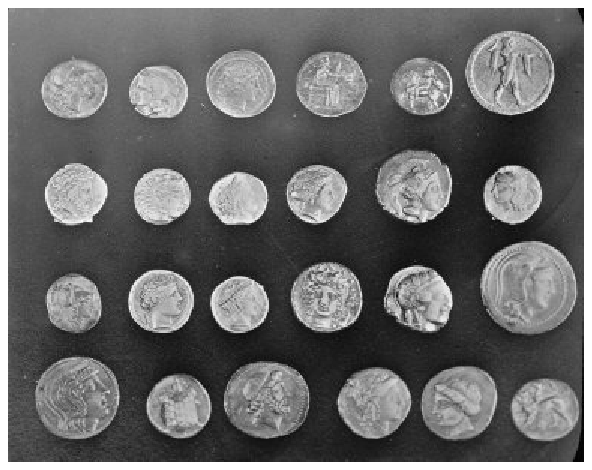

(<Figure size 576x454.5 with 1 Axes>,
 <matplotlib.axes._axes.Axes at 0x25c65789eb8>)

In [3]:
image = data.coins()
# switch to float to avoid numerical issue with uint8
image = img_as_float(image)
# discard the color channel (if any)
size = image.shape[:2]
print("Image size:", size)
imshow(image)

In [4]:
graph = hg.get_4_adjacency_graph(size)

In [5]:
def buildTree(graph, edge_weights=None, areamin=500, tree="BPT"):
    if tree == "BPT":
        # --- Build the BPT
        t1a, altitudesa = hg.bpt_canonical(graph, edge_weights)
        # and remove small regions from it
        t1b, altitudesb = hg.filter_small_nodes_from_tree(t1a, altitudesa, areamin)
        t1, altitudes = hg.canonize_hierarchy(t1b, altitudesb)
        return t1, altitudes
    else:
        if tree == "ToS":    
            t1a, altitudesa = hg.component_tree_tree_of_shapes_image2d(image)
        elif tree == 'maxTree':
            t1a, altitudesa = hg.component_tree_max_tree(graph, image)
        elif tree == "minTree":
            t1a, altitudesa = hg.component_tree_min_tree(graph, image)
        else:
            raise ValueError("Error. Possible choices are BPT, maxTree, minTree or ToS")
        area = hg.attribute_area(t1a)
        condRemoval = area < areamin
        
        t1, node_map = hg.simplify_tree(t1a, condRemoval)
        a1 = altitudesa[node_map]
        return t1, a1
    

In [6]:
# Circularity is 1 for a disk, 0 if not
def circularity(tree):
    g = hg.CptHierarchy.get_leaf_graph(tree)
    size = hg.CptGridGraph.get_shape(g)
    emb = hg.EmbeddingGrid2d(size)
    coord = emb.lin2grid(np.arange(tree.num_leaves()))

    m = np.zeros((tree.num_leaves(), 6), dtype=np.float64)
    m[:, 0] = 1
    m[:, 1] = coord[:, 0]
    m[:, 2] = coord[:, 1]
    m[:, 3] = coord[:, 0] * coord[:, 1]
    m[:, 4] = coord[:, 0] * coord[:, 0]
    m[:, 5] = coord[:, 1] * coord[:, 1]
    m = hg.accumulate_sequential(tree, m, hg.Accumulators.sum)
    m00 = m[:, 0]
    m10 = m[:, 1]
    m01 = m[:, 2]
    m11 = m[:, 3]
    m20 = m[:, 4]
    m02 = m[:, 5]
    xmean = m10 / m00
    ymean = m01 / m00
    xvar = m20 / m00 - xmean * xmean
    yvar = m02 / m00 - ymean * ymean
    xycovar = m11 / m00 - xmean*ymean
    lambda1 = np.maximum(0, 0.5 * (xvar + yvar + np.sqrt(4 * xycovar * xycovar + (xvar - yvar) * (xvar - yvar))))
    lambda2 = np.maximum(0, 0.5 * (xvar + yvar - np.sqrt(4 * xycovar * xycovar + (xvar - yvar) * (xvar - yvar))))
    return np.nan_to_num(lambda2[tree.num_leaves():] / lambda1[tree.num_leaves():])

def attribut(tree, attr, edge_weights):
    if attr=="circ":
        attr = circularity(tree)
    elif attr == "averageGradContour":
        attr = hg.attribute_contour_strength(tree, edge_weights)[tree.num_leaves():]
    elif attr == "compactness":
        attr = hg.attribute_compactness(tree, normalize=False)[tree.num_leaves():]
    else:
        print("Error. Attribute not known")
    return attr


In [7]:
interact_manual.opts['manual_name'] = 'Run Shaping'
@interact_manual
def show_articles_more_than(sTree=['ToS', 'BPT', 'maxTree', 'minTree'], 
                            sAttr=['averageGradContour', 'compactness', 'circ'],
                            sminArea=(10, 1000, 10)):  
    global graph

    print("First tree")
    edge_weights = hg.weight_graph(graph, image, hg.WeightFunction.L2)
    t1, altitudes = buildTree(graph, edge_weights, tree=sTree, areamin=sminArea)
    g = hg.CptHierarchy.get_leaf_graph(t1)
    g_shape = hg.CptGridGraph.get_shape(g)
    edge_weights = hg.weight_graph(g, resize(image, g_shape, anti_aliasing=True), hg.WeightFunction.L2)
    
    attr = attribut(t1, sAttr, edge_weights)
    
    # Now the second tree t2
    sources, targets = t1.edge_list()
    g2 = hg.UndirectedGraph(t1.num_vertices() - t1.num_leaves())
    g2.add_edges(sources[t1.num_leaves():] - t1.num_leaves(), targets[t1.num_leaves():] - t1.num_leaves())
    
    # and compute the max tree
    print("Second tree")
    t2 , a2 = hg.component_tree_max_tree(g2, attr)
    
    # Compute extinction values
    extinction = hg.attribute_dynamics(t2, a2)
    
    # The regions are the extrema of t2
    extrem = hg.attribute_extrema(t2, a2)
    
    extrema_nodes, = np.nonzero(extrem)

    # labelisations of vertices with extrema indices
    node_labels_t2 = np.zeros(t2.num_vertices(), dtype=np.int64)
    node_labels_t2[extrema_nodes] = extrema_nodes
    
    # labelisation of the leaves of t2 (ie, inner nodes of t1) by the index of the extrema they belong to (or 0 if there are not in an extrema)
    extrema_labels_t2 = hg.propagate_sequential(t2,  node_labels_t2, np.logical_not(extrem))[:t2.num_leaves()]
    
    # equivalent labelisation of the inner nodes of t1
    attr_extrema_labels_t1 = np.concatenate((np.zeros(t1.num_leaves(), dtype=np.int64), extrema_labels_t2))
    
    # There may be connected components of t1 with the same labels, we only keep  the largest node of each connected component,
    # ie. the one whose parent has a different label value
    attr_extrema_labels_t1[attr_extrema_labels_t1 == attr_extrema_labels_t1[t1.parents()]] = 0
    
    # we replace non zero labels by the associated extinction value
    representent_nodes, = np.nonzero(attr_extrema_labels_t1)
    representent_nodes_extinction = np.zeros_like(attr_extrema_labels_t1, dtype=np.float64)
    representent_nodes_labels = attr_extrema_labels_t1[representent_nodes]
    representent_nodes_extinction[representent_nodes] = extinction[representent_nodes_labels]
    
    print("Max contour")
    # maximal extinction on contours
    saliency_map = hg.accumulate_on_contours(t1, representent_nodes_extinction, hg.Accumulators.max)
    
    # drawing
    cutKhal = hg.graph_4_adjacency_2_khalimsky(g, saliency_map)
    #imageio.imsave("res.png", cutKhal / np.max(cutKhal))
    imshow(cutKhal, cmap='gray_r')
    return 

interactive(children=(Dropdown(description='sTree', options=('ToS', 'BPT', 'maxTree', 'minTree'), value='ToS')…